> 로지스틱 (2) -- 손실함수의 비교 //  깊은신경망 (1) -- 로지스틱의 한계, DNN을 이용한 해결, DNN으로 해결가능한 다양한 예제

# 강의영상 

<https://youtube.com/playlist?list=PLQqh36zP38-zE7DY6FYyM9eVy0HTIkwNB>

# imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## 시각화를 위한 준비함수들 

**준비1** loss_fn을 plot하는 함수

In [2]:
def plot_loss(loss_fn,ax=None):
    if ax==None:
        fig = plt.figure()
        ax=fig.add_subplot(1,1,1,projection='3d')
        ax.elev=15;ax.azim=75
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.15),torch.arange(-1,10,0.15),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    ax.scatter(w0hat,w1hat,loss,s=0.1,alpha=0.2) 
    ax.scatter(-1,5,l(-1,5),s=200,marker='*') # 실제로 -1,5에서 최소값을 가지는건 아님.. 

- $y_i \sim Ber(\pi_i),\quad$ where $\pi_i = \frac{\exp(-1+5x_i)}{1+\exp(-1+5x_i)}$ 에서 생성된 데이터 한정하여 손실함수가 그려지게 되어있음. 

**준비2: for문 대신 돌려주고 epoch마다 필요한 정보를 기록하는 함수**

In [3]:
def learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    what_history = [] 

    for epoc in range(1000): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        optimizr.zero_grad() 

        ## record 
        if epoc % 20 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            what_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    return yhat_history, loss_history, what_history

- 20에폭마다 yhat, loss, what을 기록

**준비3: 애니메이션을 만들어주는 함수**

In [4]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [5]:
def show_lrpr2(net,loss_fn,optimizr,suptitle=''):
    yhat_history,loss_history,what_history = learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7,2.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax2.set_xticks([]);ax2.set_yticks([]);ax2.set_zticks([])
    ax2.elev = 15; ax2.azim = 75

    ## ax1: 왼쪽그림 
    ax1.plot(x,v,'--')
    ax1.scatter(x,y,alpha=0.05)
    line, = ax1.plot(x,yhat_history[0],'--') 
    plot_loss(loss_fn,ax2)
    fig.suptitle(suptitle)
    fig.tight_layout()

    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        ax2.scatter(np.array(what_history)[epoc,0],np.array(what_history)[epoc,1],loss_history[epoc],color='grey')
        return line

    ani = animation.FuncAnimation(fig, animate, frames=30)
    plt.close()
    return ani

- 준비1에서 그려진 loss 함수위에, 준비2의 정보를 조합하여 애니메이션을 만들어주는 함수 

# Logistic intro (review + $\alpha$)

`-` 모델: $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수 있음 <--- 외우세요!!!

- $y_i \sim Ber(\pi_i),\quad $ where $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$

- $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$ 

- $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$ <--- 외우세요!!

`-` toy example 

In [6]:
x=torch.linspace(-1,1,2000).reshape(2000,1)
w0= -1 
w1= 5 
u = w0+x*w1 
v = torch.exp(u)/(1+torch.exp(u)) # v=πi, 즉 확률을 의미함
y = torch.bernoulli(v) 

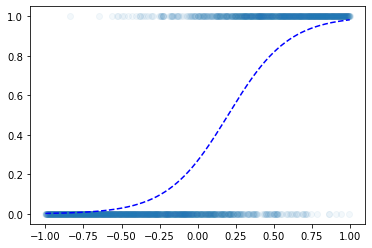

In [7]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,v,'--b')

`-` step1: yhat을 만들기 

(방법1)

In [8]:
torch.manual_seed(43052) 
l1=torch.nn.Linear(1,1) 
a1=torch.nn.Sigmoid()
yhat= a1(l1(x)) # yhat=net(x) 라고 쓰고싶어 사실 
yhat

tensor([[0.3775],
        [0.3774],
        [0.3773],
        ...,
        [0.2327],
        [0.2327],
        [0.2326]], grad_fn=<SigmoidBackward0>)

(방법2)

$x \overset{l1}{\to} u \overset{a1}{\to} v = \hat{y}$

$x \overset{net}{\to} \hat{y}$

In [9]:
torch.manual_seed(43052) 
l1=torch.nn.Linear(1,1) 
a1=torch.nn.Sigmoid()
net = torch.nn.Sequential(l1,a1)
yhat= net(x) # a1(l1(x)) 
yhat

tensor([[0.3775],
        [0.3774],
        [0.3773],
        ...,
        [0.2327],
        [0.2327],
        [0.2326]], grad_fn=<SigmoidBackward0>)

(방법3)

In [10]:
torch.manual_seed(43052) 
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
yhat= net(x) # a1(l1(x)) 
yhat

tensor([[0.3775],
        [0.3774],
        [0.3773],
        ...,
        [0.2327],
        [0.2327],
        [0.2326]], grad_fn=<SigmoidBackward0>)

`-` step2

(방법1)

In [11]:
loss = torch.mean((y-yhat)**2) 
loss

tensor(0.2863, grad_fn=<MeanBackward0>)

(방법2)

In [12]:
loss_fn = torch.nn.MSELoss() 
loss = loss_fn(yhat,y) 
loss

tensor(0.2863, grad_fn=<MseLossBackward0>)

`-` step 1~4 

In [13]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.01) 

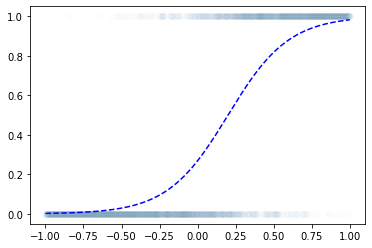

In [14]:
plt.plot(x,y,'o',alpha=0.01)
plt.plot(x,v,'--b')

In [15]:
for epoc in range(3000): 
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

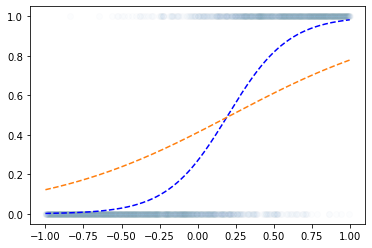

In [16]:
plt.plot(x,y,'o',alpha=0.01)
plt.plot(x,v,'--b')
plt.plot(x,net(x).data,'--')

# 로지스틱--BCEloss 

`-` step 1~4 

In [17]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.01) 

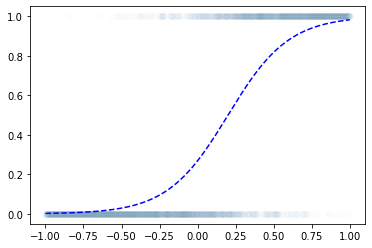

In [18]:
plt.plot(x,y,'o',alpha=0.01)
plt.plot(x,v,'--b')

In [19]:
for epoc in range(3000): 
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) # -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

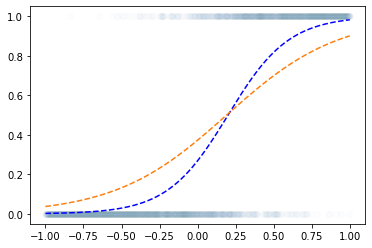

In [20]:
plt.plot(x,y,'o',alpha=0.01)
plt.plot(x,v,'--b')
plt.plot(x,net(x).data,'--')

`-` 왜?? "linear -> sigmoid" 로 yhat을 구하고 BCELoss로 loss를 계산하면 그 모양이 convex하게 되므로 

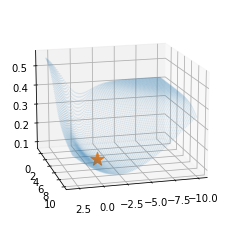

In [21]:
plot_loss(torch.nn.MSELoss())

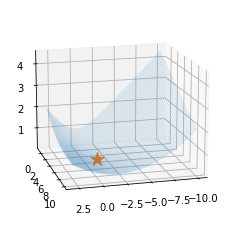

In [22]:
plot_loss(torch.nn.BCELoss())

## 시각화1: MSE, 좋은초기값

In [23]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [24]:
l1,a1 = net 

In [25]:
l1.weight.data = torch.tensor([[-1.0]])
l1.bias.data = torch.tensor([-3.0])

In [26]:
show_lrpr2(net,loss_fn,optimizr,'MSELoss, good_init // SGD') 

## 시각화2: MSE, 나쁜초기값

In [27]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [28]:
l1,a1 = net 

In [29]:
l1.weight.data = torch.tensor([[-1.0]])
l1.bias.data = torch.tensor([-10.0])

In [30]:
show_lrpr2(net,loss_fn,optimizr,'MSELoss, bad_init // SGD') 

## 시각화3: BCE, 좋은초기값

In [31]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [32]:
l1,a1 = net 

In [33]:
l1.weight.data = torch.tensor([[-1.0]])
l1.bias.data = torch.tensor([-3.0])

In [34]:
show_lrpr2(net,loss_fn,optimizr,'BCELoss, good_init // SGD') 

## 시각화4: BCE, 나쁜초기값

In [35]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [36]:
l1,a1 = net 

In [37]:
l1.weight.data = torch.tensor([[-1.0]])
l1.bias.data = torch.tensor([-10.0])

In [38]:
show_lrpr2(net,loss_fn,optimizr,'BCELoss, bad_init // SGD') 

# 로지스틱--Adam (국민옵티마이저)

`-` Adam은 SGD에 비하여 2가지 면에서 개선점이 있음. 
1. 몰라도 됩니다.. 
2. 가속도의 개념 

## 시각화1: MSE, 좋은초기값 --> 이걸 아담으로!

In [39]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.Adam(net.parameters(),lr=0.05) 

In [40]:
l1,a1 = net 

In [41]:
l1.weight.data = torch.tensor([[-1.0]])
l1.bias.data = torch.tensor([-3.0])

In [42]:
show_lrpr2(net,loss_fn,optimizr,'MSELoss, good_init // Adam') 

## 시각화2: MSE, 나쁜초기값 --> 이걸 아담으로! (혼자해봐요..)

## 시각화3: BCE, 좋은초기값 --> 이걸 아담으로! (혼자해봐요..)

### 시각화4: BCE, 나쁜초기값 --> 이걸 아담으로! (혼자해봐요..)

# 깊은신경망--로지스틱 회귀의 한계 

## 신문기사 (데이터의 모티브)

`-` [스펙이 높아도 취업이 안된다고 합니다..](https://www.joongang.co.kr/article/23637092#home)

**중소·지방 기업 "뽑아봤자 그만두니까"**

중소기업 관계자들은 고스펙 지원자를 꺼리는 이유로 높은 퇴직률을 꼽는다. 여건이 좋은 대기업으로 이직하거나 회사를 관두는 경우가 많다는 하소연이다. 고용정보원이 지난 3일 공개한 자료에 따르면 중소기업 청년취업자 가운데 49.5%가 2년 내에 회사를 그만두는 것으로 나타났다.

중소 IT업체 관계자는 "기업 입장에서 가장 뼈아픈 게 신입사원이 그만둬서 새로 뽑는 일"이라며 "명문대 나온 스펙 좋은 지원자를 뽑아놔도 1년을 채우지 않고 그만두는 사원이 대부분이라 우리도 눈을 낮춰 사람을 뽑는다"고 말했다.

## 가짜데이터 

`-` 위의 기사를 모티브로 한 데이터 

In [51]:
df=pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/posts/2022-10-04-dnnex0.csv')
df

x  underlying    y
0    -1.000000    0.000045  0.0
1    -0.998999    0.000046  0.0
2    -0.997999    0.000047  0.0
3    -0.996998    0.000047  0.0
4    -0.995998    0.000048  0.0
...        ...         ...  ...
1995  0.995998    0.505002  0.0
1996  0.996998    0.503752  0.0
1997  0.997999    0.502501  0.0
1998  0.998999    0.501251  1.0
1999  1.000000    0.500000  1.0

[2000 rows x 3 columns]

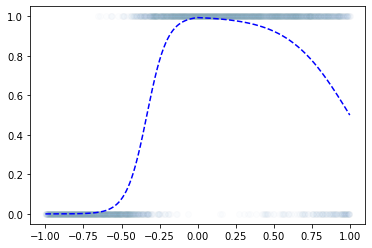

In [52]:
plt.plot(df.x,df.y,'o',alpha=0.01)
plt.plot(df.x,df.underlying, '--b')

## 로지스틱 회귀로 적합

In [53]:
x=torch.tensor(df.x).float().reshape(-1,1)
y=torch.tensor(df.y).float().reshape(-1,1) 

In [54]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True), 
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.Adam(net.parameters()) 

In [55]:
for epoc in range(6000): 
    ## step1
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y) 
    ## step3 
    loss.backward() 
    ## step4
    optimizr.step()
    optimizr.zero_grad()

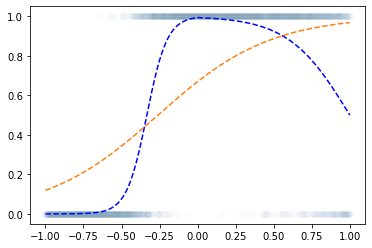

In [56]:
plt.plot(x,y,'o',alpha=0.01)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data, '--')

`-` 이거는 `epoc=60억`해도 주황색 점선은 절대 파란색 점선이 될 수 없다. 

## 해결책

`-` sigmoid를 취하기 전의 상태가 꺽인 그래프여야 한다. 

In [57]:
sig = torch.nn.Sigmoid()

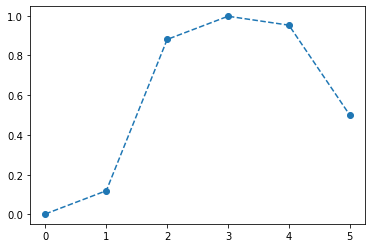

In [58]:
plt.plot(sig(torch.tensor([-6,-2,2,6.0,3,0])),'--o' )

# 깊은신경망--DNN을 이용한 해결 

`-` 목표: 아래와 같은 벡터 ${\boldsymbol u}$를 만들어보자. 

${\boldsymbol u} = [u_1,u_2,\dots,u_{2000}], \quad u_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$

## 꺽인 그래프를 만드는 방법1

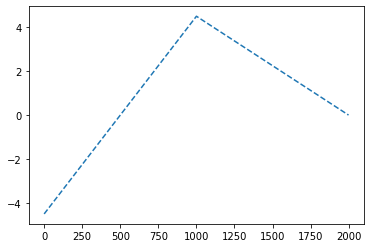

In [59]:
u= [9*xi+4.5 if xi<0 else -4.5*xi+4.5 for xi in x.reshape(-1).tolist()]
plt.plot(u,'--')

## 꺽인 그래프를 만드는 방법2

`-` 전략: 선형변환 $\to$ ReLU $\to$ 선형변환 

(예비학습) ReLU 함수란?

$ReLU(x) = \max(0,x)$

In [60]:
rlu =torch.nn.ReLU()

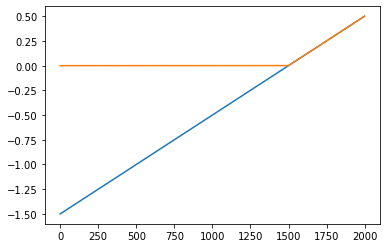

In [61]:
plt.plot(x-0.5)
plt.plot(rlu(x-0.5))

***(선형변환1)***

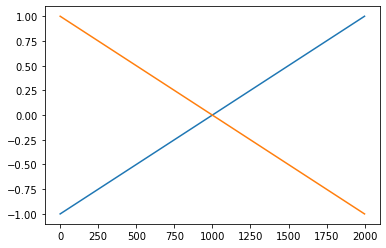

In [62]:
plt.plot(x)
plt.plot(-x)

***(렐루)***

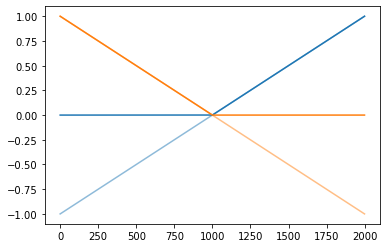

In [63]:
plt.plot(x,alpha=0.5,color='C0')
plt.plot(-x,alpha=0.5,color='C1')
plt.plot(rlu(x),color='C0')
plt.plot(rlu(-x),color='C1')

***(선형변환2)***

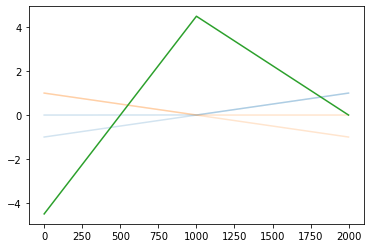

In [64]:
plt.plot(x,alpha=0.2,color='C0')
plt.plot(-x,alpha=0.2,color='C1')
plt.plot(rlu(x),color='C0',alpha=0.2)
plt.plot(rlu(-x),color='C1',alpha=0.2)
plt.plot(-4.5*rlu(x)+-9*rlu(-x)+4.5,color='C2')
#plt.plot(u)

***(시그모이드)***

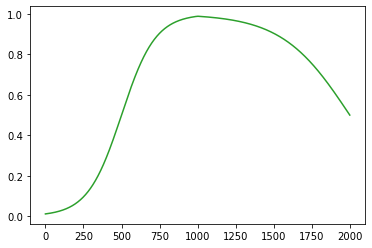

In [65]:
plt.plot(sig(-4.5*rlu(x)+-9*rlu(-x)+4.5),color='C2')

정리하면!

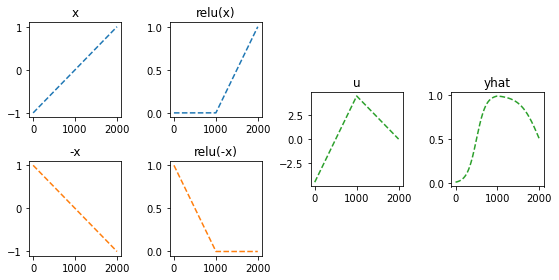

In [66]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title('x'); ax1.plot(x,'--',color='C0')
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title('-x'); ax2.plot(-x,'--',color='C1')
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title('relu(x)'); ax3.plot(rlu(x),'--',color='C0')
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title('relu(-x)'); ax4.plot(rlu(-x),'--',color='C1')
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title('u'); ax5.plot(-4.5*rlu(x)-9*rlu(-x)+4.5,'--',color='C2')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('yhat'); ax6.plot(sig(-4.5*rlu(x)-9*rlu(-x)+4.5),'--',color='C2')
fig.tight_layout()

- 이런느낌으로 $\hat{\boldsymbol y}$을 만들면 된다. 

## torch.nn.Linear()를 이용한 꺽인 그래프 구현 

`-` 구현

In [67]:
l1 = torch.nn.Linear(in_features=1,out_features=2,bias=True)
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(in_features=2,out_features=1,bias=True)
a2 = torch.nn.Sigmoid()

In [68]:
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0, 0.0])

In [69]:
l2.weight.data= torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [70]:
net = torch.nn.Sequential(l1,a1,l2,a2) 

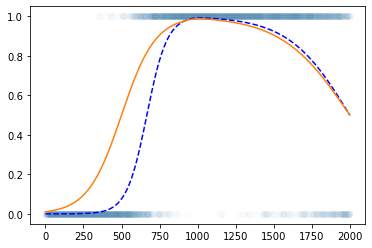

In [71]:
plt.plot(y,'o',alpha=0.02)
plt.plot(df.underlying,'--b')
#plt.plot(a2(l2(a1(l1(x)))).data)
plt.plot(net(x).data)

`-` 수식표현

`(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$

`(2)` $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\  x_n & -x_n\end{bmatrix}$

- ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
- ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$

`(3)` $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\  \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$

`(4)` $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$

$\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots  \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$ 

- ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
- $b^{(2)}=4.5$

`(5)` $net({\bf X})=(a_2 \circ l_2 \circ a_1\circ l_1)({\bf X})=\text{sig}\Big(\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\Big)$

$\quad =\begin{bmatrix} \text{sig}\Big(-4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5\Big) \\ \text{sig}\Big(-4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \Big)\\ \dots  \\ \text{sig}\Big(-4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \Big)\end{bmatrix}$ 


`-` 차원만 따지자

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

## Step1 ~ Step4

In [72]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1), 
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [73]:
for epoc in range(3000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

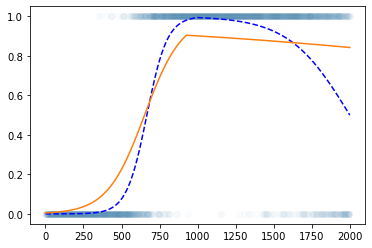

In [74]:
plt.plot(y,'o',alpha=0.02)
plt.plot(df.underlying,'--b')
plt.plot(net(x).data)

`-` 추가로 3000번 더

In [75]:
for epoc in range(3000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

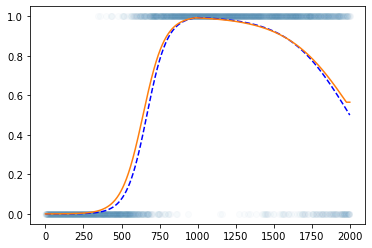

In [76]:
plt.plot(y,'o',alpha=0.02)
plt.plot(df.underlying,'--b')
plt.plot(net(x).data)

# 깊은신경망--DNN으로 해결가능한 다양한 예제

## 예제1

In [78]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/posts/2022-10-04-dnnex1.csv')
df

x  underlying    y
0    -1.000000    0.999877  1.0
1    -0.998999    0.999875  1.0
2    -0.997999    0.999873  1.0
3    -0.996998    0.999871  1.0
4    -0.995998    0.999869  1.0
...        ...         ...  ...
1995  0.995998    0.000123  0.0
1996  0.996998    0.000123  0.0
1997  0.997999    0.000123  0.0
1998  0.998999    0.000123  0.0
1999  1.000000    0.000123  0.0

[2000 rows x 3 columns]

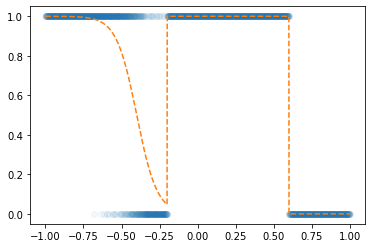

In [79]:
plt.plot(df.x,df.y,'o',alpha=0.05)
plt.plot(df.x,df.underlying,'--')

`-` 데이터정리 

In [80]:
x= torch.tensor(df.x).float().reshape(-1,1)
y= torch.tensor(df.y).float().reshape(-1,1)

`-` for문을 돌리기 위한 준비 

In [81]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [82]:
for epoc in range(20000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

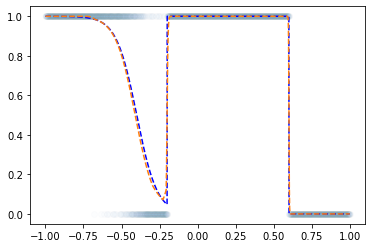

In [83]:
plt.plot(x,y,'o',alpha=0.01)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--')

## 예제2

In [84]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/posts/2022-10-04-dnnex2.csv')
df

x  underlying          y
0    -1.000000   14.791438  14.486265
1    -0.999000   14.756562  14.832600
2    -0.997999   14.721663  15.473211
3    -0.996999   14.686739  14.757734
4    -0.995998   14.651794  15.042901
...        ...         ...        ...
1995  0.995998    5.299511   5.511416
1996  0.996999    5.322140   6.022263
1997  0.997999    5.344736   4.989637
1998  0.999000    5.367299   5.575369
1999  1.000000    5.389829   5.466730

[2000 rows x 3 columns]

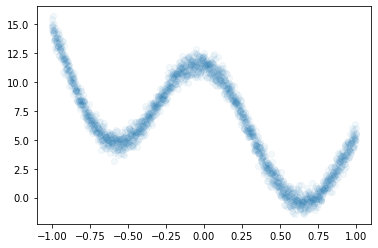

In [85]:
plt.plot(df.x,df.y,'o',alpha=0.05)

`-` 데이터준비 

In [86]:
x= torch.tensor(df.x).float().reshape(-1,1)
y= torch.tensor(df.y).float().reshape(-1,1)

`-` for문 돌릴 준비 

In [87]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1) 
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

`-` step1~4

In [88]:
for epoc in range(20000):
    ## 1
    yhat = net(x) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

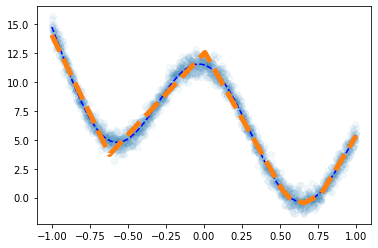

In [89]:
plt.plot(df.x,df.y,'o',alpha=0.05)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--',lw=5)

`-` for문 돌릴 준비 

In [90]:
torch.manual_seed(5)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1) 
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

`-` step1~4

In [91]:
for epoc in range(20000):
    ## 1
    yhat = net(x) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

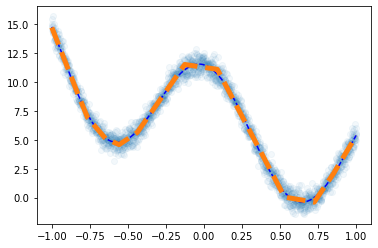

In [92]:
plt.plot(df.x,df.y,'o',alpha=0.05)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--',lw=5)

## 예제3

In [93]:
import seaborn as sns

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/posts/2022-10-04-dnnex3.csv')
df

x1        x2    y
0    -0.874139  0.210035  0.0
1    -1.143622 -0.835728  1.0
2    -0.383906 -0.027954  0.0
3     2.131652  0.748879  1.0
4     2.411805  0.925588  1.0
...        ...       ...  ...
1995 -0.002797 -0.040410  0.0
1996 -1.003506  1.182736  0.0
1997  1.388121  0.079317  0.0
1998  0.080463  0.816024  1.0
1999 -0.416859  0.067907  0.0

[2000 rows x 3 columns]

<AxesSubplot:xlabel='x1', ylabel='x2'>

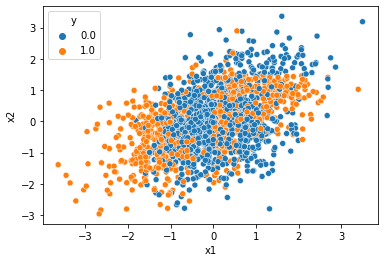

In [95]:
sns.scatterplot(data=df,x='x1',y='x2',hue='y')

`-` 데이터준비

In [96]:
x1= torch.tensor(df.x1).float().reshape(-1,1)
x2= torch.tensor(df.x2).float().reshape(-1,1)
X = torch.concat([x1,x2],axis=1)
y=  torch.tensor(df.y).float().reshape(-1,1)

`-` for문 돌릴 준비

In [97]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [98]:
for epoc in range(20000):
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [102]:
df2= df.assign(yhat=yhat.data.reshape(-1))

<AxesSubplot:xlabel='x1', ylabel='x2'>

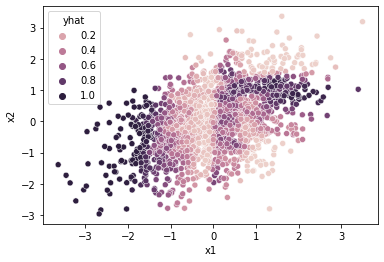

In [103]:
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat')